### Marco puzzle

Puzzle: Position 11 points on the number line such that the sum of pairwise distances is maximized. Maximum distance between any two points must not exceed 1.

Theoretical solution too difficult but simulations is easy :-)

* We generate points randomly (but always two points in the extremes 0 and 1). [blue]
* We compare relative to putting points on a grid. [orange]
* We noticed that when points are close to extremes, the sum of pairwise distances was high. Thus we generate also a set of points at extremes. When odd number, position of last point didn't seem to matter, so we put that in the middle. [green]

In [17]:
import numpy as np
import scipy as sp
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [90]:
pdist = sp.spatial.distance.pdist

### Generate points

From 3 to 11, run `n_sim` simulations where in each simluation a sets of points are randomly placed between 0 and 1 + two points at the extremes. Also generate a set of points in a grid, and a set of points at the extremes (if odd number, +1 in the middle).

In [91]:
n_sim = 10_000
n_sim = 1_000
nums = list(range(3, 12))

positions = []
for i, num_points in enumerate(nums):
    # Generate random points uniformly + two points at extremes
    positions_i = np.random.uniform(size=(n_sim, num_points-2))
    positions_i = np.c_[positions_i, np.ones(n_sim), np.zeros(n_sim)]
   
    # Calculate pairwise distances between all points per simulation
    sum_ = positions_i.sum(1)
    pairwise_distances = np.apply_along_axis(lambda x: pdist(x.reshape(num_points, 1)), 1, positions_i)

    # Turn numpy array into data frame
    positions_i = pd.DataFrame(positions_i)
    positions_i.columns = [f'pos_{j}' for j in range(num_points)]
    positions_i['sum'] = sum_ # Total sum (sum point coords)
    positions_i['sum_distances'] = pairwise_distances.sum(1) # Total sum of pariwise distances
    positions_i['mean_distances'] = pairwise_distances.mean(1) # Mean of pairwise distances
    positions_i['method'] = 'uniform' # The method of generating these points (uniformly in (0, 1))
    
    # Generate an extra data point based on grid & add to data frame
    uniform_pos = np.arange(0, 1.1, 1/(num_points - 1))
    pairwise_distances = pdist(uniform_pos.reshape(num_points, 1))
    uniform_row = {f'pos_{j}': x for j, x in enumerate(uniform_pos)}
    uniform_row.update(dict(sum=uniform_pos.sum(), sum_distances=pairwise_distances.sum(),
                            mean_distances=pairwise_distances.mean(), method='grid'))
    positions_i = positions_i.append(uniform_row, ignore_index=True)
    
    # Generate an extra data point by putting all points evenly in extremes.
    # If uneven number of points - last point in center
    num_extreme = num_points // 2
    extremes_pos = np.r_[np.repeat(0, num_extreme), np.repeat(1, num_extreme)]
    if num_points % 2 == 1:
        extremes_pos = np.r_[extremes_pos, 0.5]
    pairwise_distances = pdist(extremes_pos.reshape(num_points, 1))
    extreme_row = {f'pos_{j}': x for j, x in enumerate(extremes_pos)}
    extreme_row.update(dict(sum=extremes_pos.sum(), sum_distances=pairwise_distances.sum(),
                            mean_distances=pairwise_distances.mean(), method='extremes'))
    positions_i = positions_i.append(extreme_row, ignore_index=True)
        
    #
    positions.append(positions_i)

Variable `positions` is a list of data frames. The first data frame contains the data for 3 points on the line, second the data for 4 points, etc. 

In [92]:
positions[0].head()

,pos_0,pos_1,pos_2,sum,sum_distances,mean_distances,method
0,0.958371,1.0,0.0,1.958371,2.0,0.666667,uniform
1,0.480100,1.0,0.0,1.480100,2.0,0.666667,uniform
2,0.338274,1.0,0.0,1.338274,2.0,0.666667,uniform
3,0.010018,1.0,0.0,1.010018,2.0,0.666667,uniform
4,0.146283,1.0,0.0,1.146283,2.0,0.666667,uniform


### Distribution plots

Plot histogram of sum of pairwise distances. Also annotate the "score" for the "grid" points and "extremes" points.

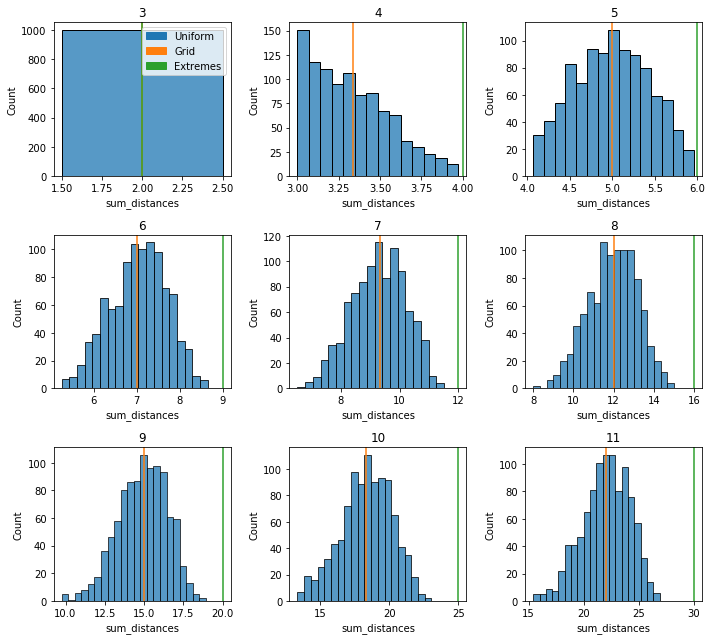

In [93]:
fig, axs = plt.subplots(figsize=(10, 9), ncols=3, nrows=int(np.ceil(len(nums) / 3)))


for i, num_points in enumerate(nums):
    ax = axs.flatten()[i]
    ax.set_title(num_points)
    sns.histplot(x=positions[i]['sum_distances'][positions[0]['method'] == 'uniform'], ax=ax)
    ax.axvline(positions[i][positions[i]['method'] == 'grid'].iloc[0]['sum_distances'], 
               color=sns.color_palette()[1])
    ax.axvline(positions[i][positions[i]['method'] == 'extremes'].iloc[0]['sum_distances'], 
               color=sns.color_palette()[2])

plt.subplot(axs[0, 0])
labels = ['Uniform', 'Grid', 'Extremes']
plt.legend([mpatches.Patch(color=c, label=l) 
            for c, l in zip(sns.color_palette()[:3], labels)],
           labels)

fig.tight_layout()

### Plot best and worst

Plot the points on their coordinates. Y-axis is sum of pairwise distances. Again also plot the "grid" and "extremes" points.

In [84]:
rows_all = []
for p, num_points in zip(positions, nums):
    ranks = np.argsort(p.query('method == "uniform"')['sum_distances'])[::-1]

    index_grid = p[p['method'] == 'grid'].index[0]
    index_extremes = p[p['method'] == 'extremes'].index[0]
    rows = p.iloc[np.r_[index_grid, index_extremes, ranks[:5], ranks[-5:]]]
    
    cols = [f'pos_{j}' for j in range(num_points)]
    rows_melted = rows.melt(id_vars=['sum_distances', 'method'], value_vars=cols)
    rows_melted['num_points'] = num_points
    
    rows_all.append(rows_melted)
rows_all = pd.concat(rows_all)
rows_all['method'] = pd.Categorical(rows_all['method'], 
                                    categories=['uniform', 'grid', 'extremes'], 
                                    ordered=True)

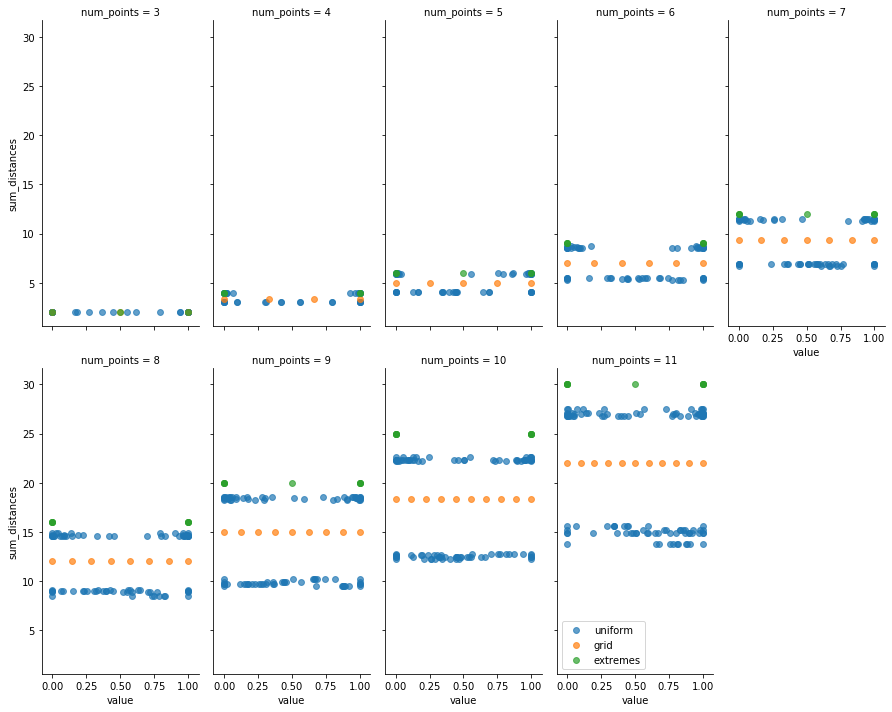

In [94]:
palette = dict(uniform='steelblue', grid='red', extremes='green')
grid = sns.FacetGrid(rows_all, col="num_points", hue="method",
                     col_wrap=5, aspect=.5, height=5)#, palette=palette)
grid.map(plt.scatter, "value", "sum_distances", s=35, alpha=.7)
plt.legend()
plt.tight_layout()